In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
from scipy.interpolate import PchipInterpolator

import csky as cy

mpl.style.use('../note_plot_style.mplstyle')

### Load in some results from differential sensitivity and model sensitivity calculations

The scripts to run these jobs are in this directory (`run_model_sens.py` and `run_differential_sens.py`)

In [3]:
def load_differential_result(dec, gamma, bins_per_decade):
    with open(f'results/dec_{dec:.1f}_index_{gamma:.1f}_bins_{bins_per_decade}_diff_sens.pkl', 'rb') as f:
        res = pickle.load(f)
    return res

def plot_differential_sens(diff_sens, color=sns.xkcd_rgb['battleship grey'],
                          label=''):
    labelled = False
    for low_e, high_e, sens in zip(diff_sens['bins'][:-1],
                                  diff_sens['bins'][1:],
                                  diff_sens['sens']):
        label = label if not labelled else ''
        plt.plot(
            [low_e, high_e], 
            [sens, sens*(high_e/low_e)**(2.-diff_sens['gamma'])],
            color=color, label=label,
        )
        labelled = True
        
def load_model(name='Crab_lowen'):
    tmp = np.loadtxt(f'ps_models/{name}.csv', delimiter=', ')
    ens = tmp.T[0]
    fls = tmp.T[1] * 1e3 # From TeV cm^-2 s^-1 to GeV cm^-2 s^-1
    return ens, fls

def make_log_spline(name='Crab_lowen'):
    ens, fls = load_model(name=name)
    log_e = np.log10(ens)
    log_f = np.log10(fls)
    log_spl = PchipInterpolator(log_e, log_f)
    return log_spl

def make_model_spline(name='Crab_lowen'):
    log_spl = make_log_spline(name=name)
    spl = lambda e: 10.**(log_spl(np.log10(e)))
    return spl

def make_binned_flux(model):
    e_bins = np.logspace(
        np.log10(model['low_e']), 
        np.log10(model['high_e']),
        51
    )
    mids = 10.**(np.log10(e_bins)[:-1] + np.diff(np.log10(e_bins))/2.)
    binned_flux = model['spl'](mids) / (mids**2) # models are E^2 dN/dE, we want dN/dE
    flux_model = cy.hyp.BinnedFlux(e_bins, binned_flux)
    return flux_model

def make_all_splines():
    model_splines = dict()
    for name in ['3C273', 'Crab_highen', 
                 'Crab_lowen', 'G40_5-0_5', 
                 'Mrk421']:
        ens, fls = load_model(name=name)
        model_splines[name] = {'spl': make_model_spline(name=name),
                               'low_e': np.min(ens),
                               'high_e': np.max(ens)}
        flux_model = make_binned_flux(model_splines[name])
        model_splines[name]['binned_flux'] = flux_model
        
    return model_splines

def load_model_results(name, dec):
    with open(f'results/dec_{dec:.1f}_model_sensitivities.pkl', 'rb') as f:
        model_res = pickle.load(f)
    sens = model_res[name]
    return sens

def find_mrf(name, dec, model_splines):
    sens = load_model_results(name, dec)
    model_fs = model_splines[name]['binned_flux'].flux[:-1]
    mrf = sens[0] / model_fs[0]
    return mrf

def plot_model_results(name, dec, color='grey', ls='solid', mode='model',
                      label='', lw=1.5, alpha=1.0):
    assert mode in ['model', 'sens'], 'Unrecognized mode'
    mrf = find_mrf(name, dec, model_splines)
    model = model_splines[name]
    es = np.logspace(
        np.log10(model['low_e']), 
        np.log10(model['high_e']),
        500
    )
    model_es = 10.**(np.log10(model_splines[name]['binned_flux'].bins_energy[:-1]) \
                     + np.diff(np.log10(model_splines[name]['binned_flux'].bins_energy))/2)
    model_fs = model_splines[name]['binned_flux'].flux[:-1]
    
    scale_factor = mrf if mode == 'sens' else 1.
    plt.plot(model_es, model_fs * scale_factor * model_es**2., 
             color=color, alpha=alpha, ls=ls, 
             lw=lw, label=label)
        
model_splines = make_all_splines()

First, plot a differential sensitivity with 5 bins per decade. Compare against that various models as well as models scaled by their (expected) model rejection factors

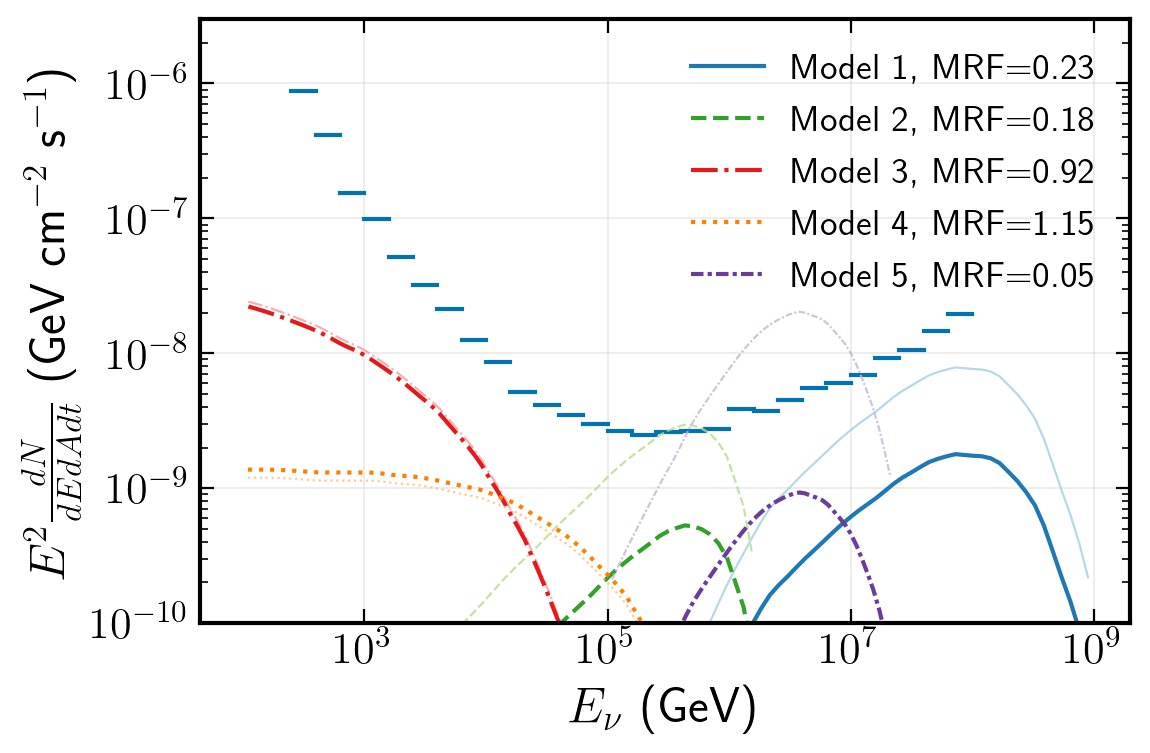

In [4]:
palette = sns.color_palette('colorblind', 20)
paired = sns.color_palette('Paired')
lss = ['-', '--', '-.', 'dotted', (0, (3, 1, 1, 1))]

n_bins=5
dec = 0.
fig, ax = plt.subplots(figsize=(6,4), dpi=200)
for gam in [2.0]:
    res = load_differential_result(dec, gam, n_bins)
    plot_differential_sens(res, color=palette[0])

for j, (name, model) in enumerate(model_splines.items()):
    mrf = find_mrf(name, dec, model_splines)
    label = f'Model {j+1}, MRF={mrf:.2f}'
    plot_model_results(name, dec, mode='model', ls=lss[j],
                      lw=0.8, alpha=0.8, color=paired[2*j])
    plot_model_results(name, dec, mode='sens', ls=lss[j], 
                      color=paired[2*j + 1], label=label)

plt.loglog()
plt.legend(loc=1, frameon=False, ncol=1, fontsize=13)
plt.xlabel(r'$E_{\nu}$ (GeV)')
plt.ylabel(r'$E^2 \frac{dN}{dEdAdt}$ (GeV cm$^{-2}$ s$^{-1}$)')
plt.grid(False, which='minor')
plt.ylim(1e-10, 3e-6)
plt.show()

Now, highlight how differential sensitivity is a function of energy bin width

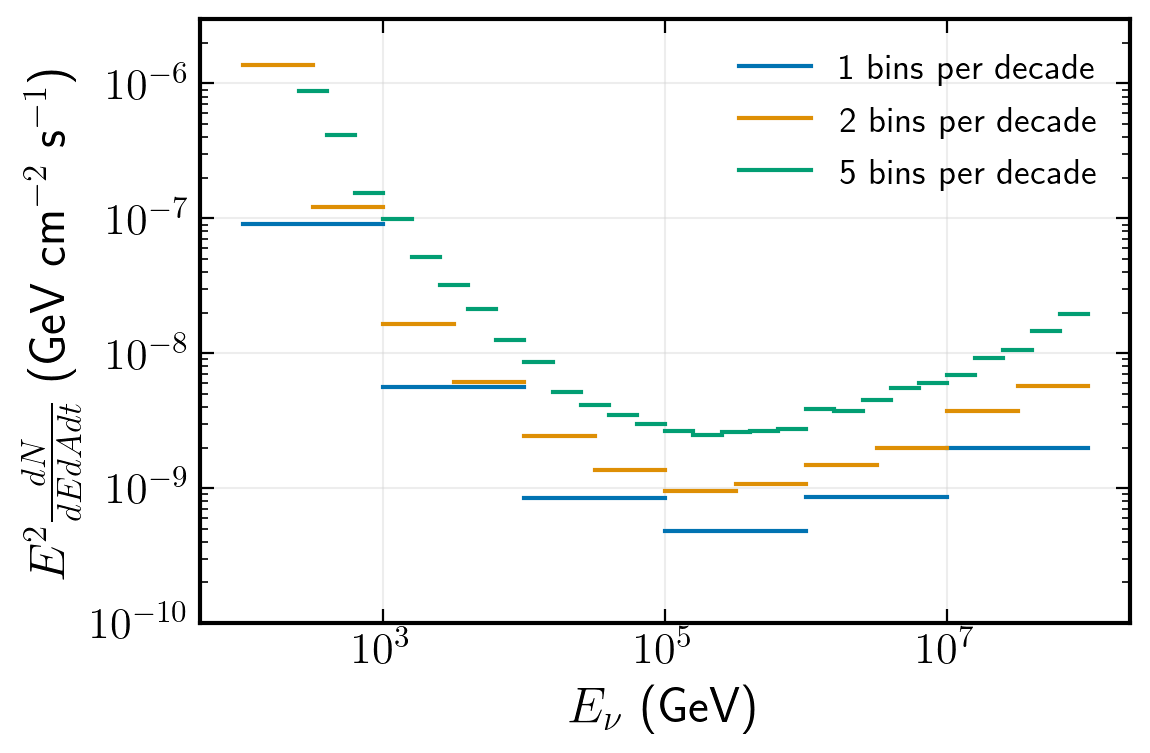

In [5]:
fig, ax = plt.subplots(figsize=(6,4), dpi=200)

for ii, n_bins in enumerate([1, 2, 5]):
    gam = 2.0
    res = load_differential_result(0., gam, n_bins)
    plot_differential_sens(res, color=palette[ii],
                          label=f'{n_bins} bins per decade')

plt.loglog()
plt.legend(loc=1, frameon=False, ncol=1, fontsize=13)
plt.xlabel(r'$E_{\nu}$ (GeV)')
plt.ylabel(r'$E^2 \frac{dN}{dEdAdt}$ (GeV cm$^{-2}$ s$^{-1}$)')
plt.grid(False, which='minor')
plt.ylim(1e-10, 3e-6)
plt.show()

And also spectral index . . . 

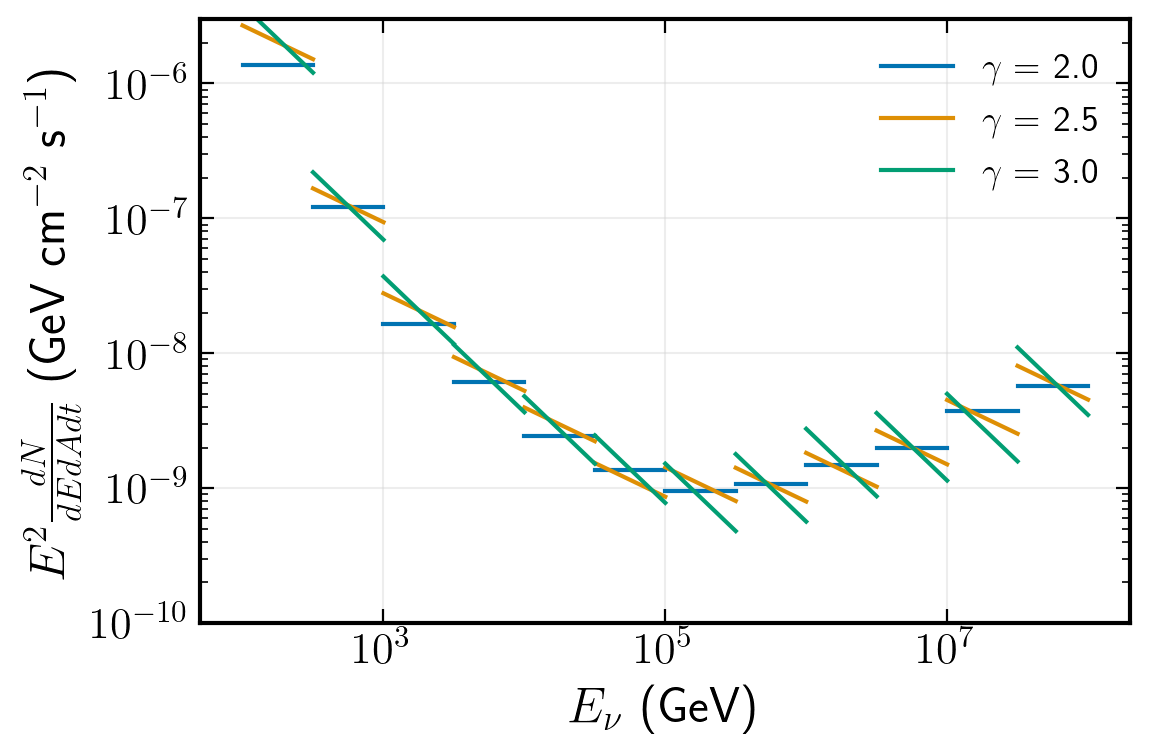

In [6]:
fig, ax = plt.subplots(figsize=(6,4), dpi=200)

n_bins = 2
i = 0
for gam in [2.0, 2.5, 3]:
    res = load_differential_result(0., gam, n_bins)
    plot_differential_sens(res, color=palette[i], label=f'$\gamma$ = {gam:.1f}')
    i += 1

plt.loglog()
plt.legend(loc=1, frameon=False, ncol=1, fontsize=13)
plt.xlabel(r'$E_{\nu}$ (GeV)')
plt.ylabel(r'$E^2 \frac{dN}{dEdAdt}$ (GeV cm$^{-2}$ s$^{-1}$)')
plt.grid(False, which='minor')
plt.ylim(1e-10, 3e-6)
plt.show()

Also just show a plot of a differential sensitivity with models that we are sensitive to in black and ones that we aren't in grey

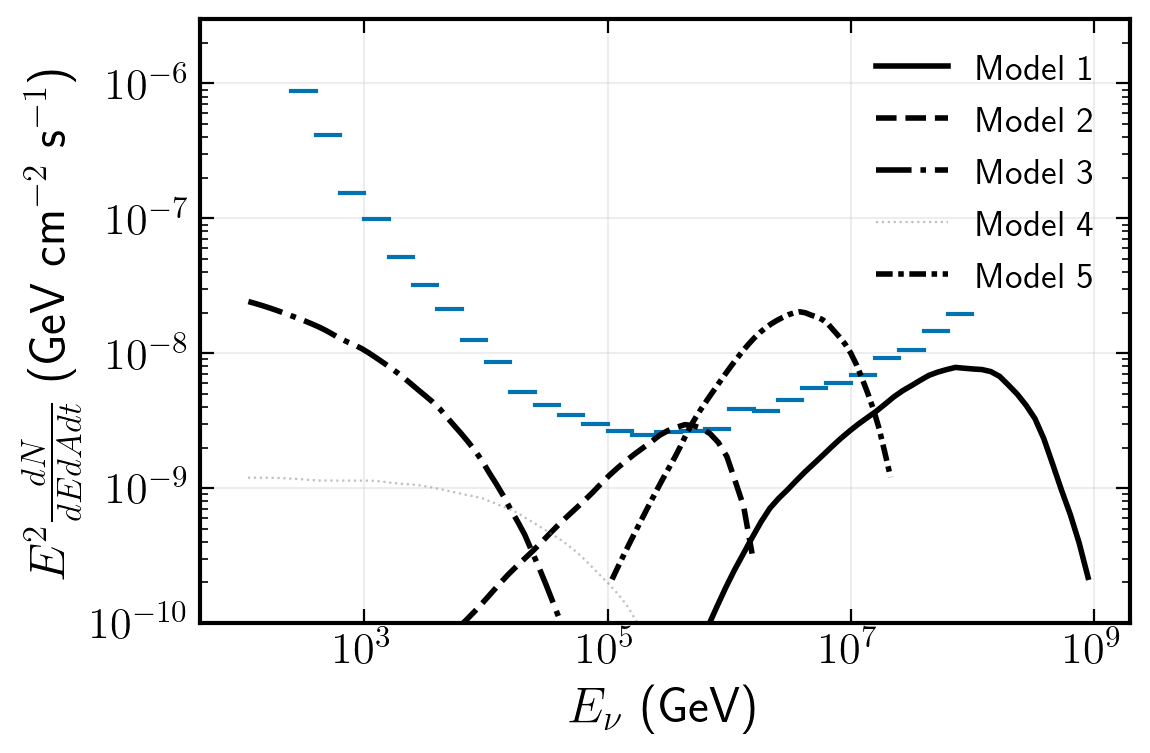

In [7]:
dec = 0.0
palette = sns.color_palette('colorblind', 20)
lss = ['-', '--', '-.', 'dotted', (0, (3, 1, 1, 1))]

n_bins=5
fig, ax = plt.subplots(figsize=(6,4), dpi=200)

res = load_differential_result(dec, 2.0, n_bins)
plot_differential_sens(res, color=palette[0])


for j, (name, model) in enumerate(model_splines.items()):
    mrf = find_mrf(name, dec, model_splines)
    if mrf < 1.0:
        lw = 2.
        alpha = 1.0
        color = 'k'
    else:
        lw = 0.8
        alpha=0.5
        color = 'grey'
    plot_model_results(name, dec, mode='model', ls=lss[j], label = f'Model {j+1}',
                      lw=lw, alpha=alpha, color=color)

plt.loglog()
plt.legend(loc=1, frameon=False, ncol=1, fontsize=13)
plt.xlabel(r'$E_{\nu}$ (GeV)')
plt.ylabel(r'$E^2 \frac{dN}{dEdAdt}$ (GeV cm$^{-2}$ s$^{-1}$)')
plt.grid(False, which='minor')
plt.ylim(1e-10, 3e-6)
plt.show()